# Graph quality evaluation
In this notebook, we'll undertake some qualitative and quantitative approaches to evaluating the quality of the various graph generation approaches we've used.

For the sake of this notebooks, "graph quality" refers to the underlying performance of the entity and relation extraction pipelines that are used to build the graph. This decision is based on the assumption that a "gold standard" graph, when built from unstructured scientific articles, is a graph where relations and entities were perfectly extracted from the original source.

In [8]:
import jsonlines
from collections import defaultdict
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42

## Use PICKLE dataset as a baseline quantitative metric
While we don't have a gold standard of entities and relations for our drought/desiccation dataset, we do have access to the [PICKLE dataset](https://huggingface.co/datasets/slotreck/pickle), which has a gold-standard set of entities and relations labeled on 250 plant science abstracts. We'll use the PICKLE dataset to set an expectation for what quantity and ratio of entities and relations we think we should see in our larger drought/desiccation corpus. If our graphs fall far short of the kind of relation/entity ratio that we see in PICKLE, we can say that likely, the recall of the method(s) is poor.

To provide more compelling evidence that PICKLE is a reasonable comparison to our drought/desiccation dataset, we'll also do some comparisons of more basic statistics like abstract length, average word length, and average sentence length.

In [2]:
with jsonlines.open('../data/pickle/pickle_all.jsonl') as reader:
    pickle = [obj for obj in reader]

In [40]:
with jsonlines.open('../data/dygiepp/model_predictions/09Apr24_dygiepp_test_formatted_data_pickle_predictions.jsonl') as reader:
    drought_des = [obj for obj in reader]

In [41]:
datasets = {
    'pickle': pickle,
    'drought/desiccation': drought_des
}

### Basic dataset comparisons

In [21]:
abstract_lens = defaultdict(list)
sent_lens = defaultdict(list)
word_lens = defaultdict(list)
for dset_name, dataset in datasets.items():
    for doc in dataset:
        abstract_lens[dset_name].append(len(doc['sentences']))
        for sent in doc['sentences']:
            sent_lens[dset_name].append(len(sent))
            for tok in sent:
                word_lens[dset_name].append(len(tok))
basic_stats = {
    'sentences per abstract': abstract_lens,
    'words per sentence': sent_lens,
    'letters per word': word_lens
}

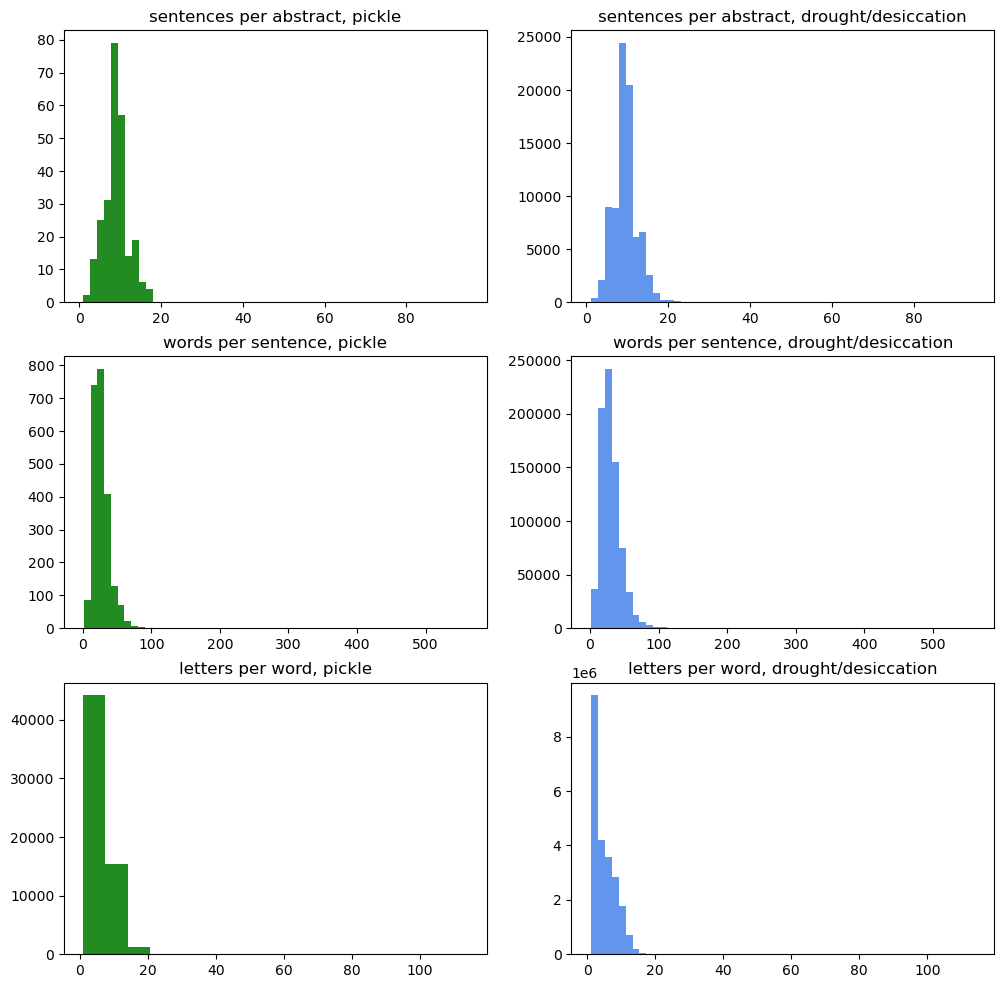

In [22]:
fig, axs = plt.subplots(3, 2, figsize=(12,12), sharex='row')
colors = {'pickle': 'forestgreen', 'drought/desiccation': 'cornflowerblue'}
for stat, axz in zip(basic_stats, axs):
    for dset_name, ax in zip(basic_stats[stat], axz):
        vals = basic_stats[stat][dset_name]
        if dset_name == 'pickle':
            _, bins, _ = ax.hist(vals, label=dset_name, color=colors[dset_name])
        elif dset_name == 'drought/desiccation':
            ax.hist(vals, bins=len(bins)*5, label=dset_name, color=colors[dset_name])
        ax.set_title(f'{stat}, {dset_name}')
plt.savefig('../data/figures/basic_dataset_statistics_comparison_pickle.pdf', format='pdf',
           bbox_inches='tight', dpi=600)

Figure caption: Histograms of basic dataset statistics for the PICKLE and drought/desiccation dataset. X-limits for each row are determined by the automatic x-limits for the drought/desiccation dataset, as it has larger ourliers in each category. Default number of bins was used for PICKLE, and 5x the number of PICKLE bins was used for drought/desiccation in each row to allow a similar level of granularity for comparison.

**For final visualization:** Add arrows indicating the bins that have outliers but can't be seen because of the scale of the graph.

### Multiple entities per sentence quantification

We also generally trust the entity extraction we did on our drought/desiccation dataset (from an anecdotal perspective), so we can further compare the two by calculating the frequency with which more than one entity appears in a sentence. The extraction method that PICKLE was designed for is limited by entities appearing together in a sentence, so we can calculate how frequently two entities in a sentence are actually connected by a relation in the gold standard. We can also calculate this for the drought/desiccation dataset, since we generally have trusted (anecdotally) the entity extraction we performed with the PICKLE-trained DyGIE++ model, so this forms another basis on which we can compare our two datasets.

In [38]:
pickle_paired_ents = defaultdict(int)
ents_per_abstract = []
for doc in pickle:
    for sent in doc['ner']:
        if len(sent) <= 1:
            pickle_paired_ents['single_or_0'] += 1
        else:
            pickle_paired_ents['multiples'] += 1

In [39]:
pickle_percent_multiples = (pickle_paired_ents['multiples']/(pickle_paired_ents['single_or_0'] + pickle_paired_ents['multiples']))*100
print(f'{pickle_percent_multiples:.2f} % of sentences in PICKLE have multiple entities.')

68.16 % of sentences in PICKLE have multiple entities.


In [43]:
drought_des_paired_ents = defaultdict(int)
for doc in drought_des:
    for sent in doc['predicted_ner']:
        if len(sent) <= 1:
            drought_des_paired_ents['single_or_0'] += 1
        else:
            drought_des_paired_ents['multiples'] += 1

In [44]:
drought_des_percent_multiples = (drought_des_paired_ents['multiples']/(drought_des_paired_ents['single_or_0'] + drought_des_paired_ents['multiples']))*100
print(f'{drought_des_percent_multiples:.2f} % of sentences in PICKLE have multiple entities.')

43.16 % of sentences in PICKLE have multiple entities.


Contextualize this comparison with the number of entities per abstract in each dataset:

In [45]:
ents_per_abstract_both = defaultdict(list)
for dset_name, dset in datasets.items():
    for doc in dset:
        entcount = 0
        try:
            for sent in doc['ner']:
                entcount += len(sent)
        except KeyError:
            for sent in doc['predicted_ner']:
                entcount += len(sent)
        ents_per_abstract_both[dset_name].append(entcount)

In [49]:
avgs = []
for dset_name, vals in ents_per_abstract_both.items():
    avg = sum(vals)/len(vals)
    avgs.append(avg)
    print(f'{dset_name} has an average of {avg:.2f} entities per abstract.')
assumed_recall = avgs[1]/avgs[0]
print(f'This comparison equates to a "recall" of {assumed_recall:.2f}.')

pickle has an average of 24.66 entities per abstract.
drought/desiccation has an average of 16.37 entities per abstract.
This comparison equates to a "recall" of 0.66.


The PICKLE-trained DyGIE++ model has a recall of ~0.8 on the PICKLE test set. This means that we would expect to find about 80% of the entities if we applied the PICKLE-trained model on the PICKLE dataset. While we have shown above that the general statistics of the drought/desiccation dataset are nearly identical to the PICKLE dataset, it's still a different sub-domain of plant science, with some different vocabulary, so it's not necessarily unexpected to see that there are 66% the number of entities per abstract.

**Todo:** Flesh out this line of reasoning further to make sure the comparison below is justified.

### Calculation of the ratio
We'll do this both for the overall dataset, as well as on a per-abstract level, so that we can compare distributions as well.

In [23]:
ents_per_abstract = defaultdict(int)
rels_per_abstract = defaultdict(int)
for doc in pickle:
    entcount = 0
    relcount = 0
    for sent in doc['ner']:
        entcount += len(sent)
    for sent in doc['relations']:
        relcount += len(sent)
    ents_per_abstract[doc['doc_key']] = entcount
    rels_per_abstract[doc['doc_key']] = relcount

In [24]:
total_ratio = sum(rels_per_abstract.values())/sum(ents_per_abstract.values())
print(f'The PICKLE dataset has a relation to entity ratio of {total_ratio:.2f}')

The PICKLE dataset has a relation to entity ratio of 0.34


In [27]:
per_doc_ratios = {doc['doc_key']: rels_per_abstract[doc['doc_key']]/ents_per_abstract[doc['doc_key']] for doc in pickle}

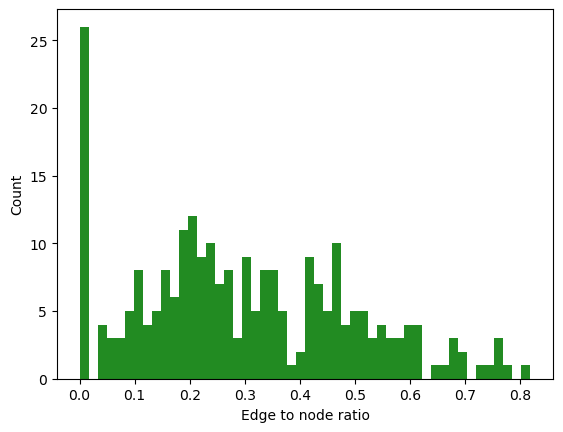

In [32]:
_ = plt.hist(per_doc_ratios.values(), bins=50, color=colors['pickle'])
_ = plt.xlabel('Edge to node ratio')
_ = plt.ylabel('Count')